#### Importing libraries

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GCNConv, GATConv, ChebConv,GATv2Conv, SAGEConv,global_max_pool
from torch_geometric.nn import knn_graph
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import gaussian_kde
from torch_geometric.utils import dense_to_sparse
from tqdm import tqdm
from sklearn.decomposition import PCA
import networkx as nx

# Modeling

In [40]:
class ImageEncoder(nn.Module):
    """
    Maps an input image [B, in_channels, H, W] down to [B, feature_dim, H/4, W/4]
    using two (Conv -> BN -> ReLU -> MaxPool) blocks.
    """
    def __init__(self, in_channels=3, feature_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Downsamples H->H/2, W->W/2
            
            # Block 2
            nn.Conv2d(32, feature_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # Downsamples H->H/4, W->W/4
        )
    
    def forward(self, x):
        """
        x: [B, in_channels, H, W]
        returns: [B, feature_dim, H/4, W/4]
        """
        return self.encoder(x)

class ImageDecoder(nn.Module):
    """
    Maps a feature map [B, feature_dim, H/4, W/4] back up to
    [B, out_channels, H, W] using two (Upsample -> Conv -> BN -> ReLU) blocks.
    """
    def __init__(self, feature_dim=64, out_channels=3):
        super().__init__()
        self.decoder = nn.Sequential(
            # Block 1
            nn.Upsample(scale_factor=2, mode='nearest'),  # H/4 -> H/2
            nn.Conv2d(feature_dim, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 2
            nn.Upsample(scale_factor=2, mode='nearest'),  # H/2 -> H
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            # Optional: BatchNorm on the final out_channels if desired
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)  # Or remove/replace with Sigmoid if it's an AE for e.g. grayscale [0,1]
        )
    
    def forward(self, x):
        """
        x: [B, feature_dim, H/4, W/4]
        returns: [B, out_channels, H, W]
        """
        return self.decoder(x)


class PairwiseMLP(nn.Module):
    """
    Given two node vectors (dim=node_dim), produce a scalar similarity score.
    score_ij = MLP([x_i || x_j]).
    """
    def __init__(self, node_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # scalar output
        )
    
    def forward(self, node_i, node_j):
        # node_i, node_j: [B, node_dim] each (or [1, node_dim] if processing one pair at a time)
        x = torch.cat([node_i, node_j], dim=-1)  # [B, 2*node_dim]
        score = self.mlp(x)  # [B, 1]
        return score


# --------------------------
# 4. GCN Encoder/Decoder (PyG)
# --------------------------
class GCNEncoder(nn.Module):
    """
    Encodes node features into latent embeddings using GCN layers.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        # Hidden layers (if more than 2)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Last layer
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_channels, out_channels))
        else:
            self.convs[0] = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        """
        x: [N, in_channels]
        edge_index: [2, E]
        edge_weight: [E] or None
        """
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
        return x


class GCNDecoder(nn.Module):
    """
    Decodes latent embeddings back to e.g. original node dimension.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        # Hidden layers (if more than 2)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Last layer
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_channels, out_channels))
        else:
            self.convs[0] = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
        return x


# ----------------------------
# 5. Full Autoencoder Pipeline
# ----------------------------
class ImageGraphAutoencoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        feature_dim=64,   # output of CNN encoder
        node_dim=64,      # dimension for node embeddings
        encoder_hidden=64,
        decoder_hidden=64,
        gcn_encoder_layers=2,
        gcn_decoder_layers=2
    ):
        """
        - in_channels: # of channels in the input image
        - feature_dim: # of feature maps from ImageEncoder
        - node_dim: dimension for node embeddings
        - encoder_hidden, decoder_hidden: hidden dims for GCN layers
        - gcn_encoder_layers, gcn_decoder_layers: number of GCNConv layers for encoder/decoder
        """
        super().__init__()
        
        # 1) CNN Encoder
        self.image_encoder = ImageEncoder(in_channels, feature_dim)
        
        # 2) MLP for pairwise adjacency
        self.pairwise_mlp = PairwiseMLP(node_dim)
        
        # 3) GCN encoder
        self.gcn_encoder = GCNEncoder(
            in_channels=node_dim,
            hidden_channels=encoder_hidden,
            out_channels=encoder_hidden,  # or some chosen latent size
            num_layers=gcn_encoder_layers
        )
        
        # 4) GCN decoder
        self.gcn_decoder = GCNDecoder(
            in_channels=encoder_hidden,
            hidden_channels=decoder_hidden,
            out_channels=node_dim,  # decode back to node_dim
            num_layers=gcn_decoder_layers
        )
        
        # 5) CNN Decoder
        self.image_decoder = ImageDecoder(feature_dim=feature_dim, out_channels=in_channels)
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        # -----------------------
        # 1) CNN Encoder -> feature maps
        # -----------------------
        feat_maps = self.image_encoder(x)  # [B, feature_dim, H/4, W/4]

        B, Fm, Hf, Wf = feat_maps.shape
        N = Hf * Wf
        
        # Reshape: [B, N, feature_dim]
        nodes_batch = feat_maps.view(B, Fm, N).permute(0, 2, 1).contiguous()  # [B, N, Fm]

        recon_list = []
        graph_representations = []
        for b_idx in range(B):
            node_features = nodes_batch[b_idx]  # [N_b, Fm]
            N_b = node_features.shape[0]

            # -----------------------
            # 2) Vectorized Adjacency Computation
            # -----------------------
            node_i = node_features.unsqueeze(1).expand(N_b, N_b, -1)  # [N_b, N_b, Fm]
            node_j = node_features.unsqueeze(0).expand(N_b, N_b, -1)  # [N_b, N_b, Fm]
            
            pairs = torch.cat([node_i, node_j], dim=2)  # [N_b, N_b, 2*Fm]
            pairs = pairs.view(N_b*N_b, -1)             # [N_b*N_b, 2*Fm]
            
            # Single pass through MLP
            scores = self.pairwise_mlp.mlp(pairs)       # [N_b*N_b, 1]
            scores = scores.view(N_b, N_b)             # [N_b, N_b]

            A_dense = F.softmax(scores, dim=-1)         # row-stochastic adjacency
            edge_index, edge_attr = dense_to_sparse(A_dense)

            # -----------------------
            # 3) GCN Encoder
            # -----------------------
            latent_nodes = self.gcn_encoder(node_features, edge_index, edge_attr)  # [N_b, encoder_hidden]
            graph_representations.append((latent_nodes, A_dense))
            # -----------------------
            # 4) GCN Decoder
            # -----------------------
            decoded_nodes = self.gcn_decoder(latent_nodes, edge_index, edge_attr)  # [N_b, node_dim]

            # -----------------------
            # 5) Reshape -> CNN Decoder
            # -----------------------
            decoded_maps = decoded_nodes.view(Fm, Hf, Wf).unsqueeze(0)  # [1, Fm, Hf, Wf]
            recon_image = self.image_decoder(decoded_maps)               # [1, C, H, W]

            recon_list.append(recon_image)

        # Combine all single-image reconstructions into [B, C, H, W]
        recon_x = torch.cat(recon_list, dim=0)
        return recon_x, graph_representations

# Data Reading and Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to [0,1] tensor [C,H,W]
])

data_root = './data'

# 2. Download EMNIST 'letters' dataset for TRAIN
emnist_train_dataset = datasets.EMNIST(
    root=data_root, split='letters',
    train=True, transform=transform, download=True
)

# 3. Convert train dataset to a numpy array (only the image part)
X_data = []
for img_tensor, _ in emnist_train_dataset:
    # `img_tensor` shape: [1, 28, 28]
    # If you want to transpose or reshape, you can do so here,
    # but usually for an autoencoder, it's fine to keep as [1, 28, 28].
    X_data.append(img_tensor.numpy())

X_data = np.array(X_data)  # shape: [N, 1, 28, 28]

# 4. Split into train/val
X_train, X_val = train_test_split(X_data, test_size=0.1, random_state=42)

# 5. Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)  # [N_train, 1, 28, 28]
X_val   = torch.FloatTensor(X_val)    # [N_val, 1, 28, 28]

print("Train set shape:", X_train.shape)
print("Val set shape:  ", X_val.shape)

Train set shape: torch.Size([112320, 1, 28, 28])
Val set shape:   torch.Size([12480, 1, 28, 28])


In [6]:
batch_size = 128

# For an autoencoder, inputs == targets
train_dataset = TensorDataset(X_train, X_train)  # (data, same data)
val_dataset   = TensorDataset(X_val,   X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 6. Prepare the TEST set
emnist_test_dataset = datasets.EMNIST(
    root=data_root, split='letters',
    train=False, transform=transform, download=True
)

# Convert test dataset to numpy array
X_test_data = []
for img_tensor, _ in emnist_test_dataset:
    X_test_data.append(img_tensor.numpy())

X_test_data = np.array(X_test_data)
X_test = torch.FloatTensor(X_test_data)

test_dataset = TensorDataset(X_test, X_test)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Test set shape: ", X_test.shape)

Test set shape:  torch.Size([20800, 1, 28, 28])


In [7]:
def plot_images(X, Y, title):
    """
    Plots pairs of images: X[i] on the top row, Y[i] on the bottom row.
    For an autoencoder, X[i] and Y[i] are the same unless you modify them.
    """
    plt.figure(figsize=(15, 5))
    for i in range(5):
        # Plot X images
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title(f"{title} X: {i}", fontsize=12)
        plt.axis('off')
        
        # Plot Y images (should be identical if autoencoder input=target)
        plt.subplot(2, 5, i + 6)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title(f"{title} Y: {i}", fontsize=12)
        plt.axis('off')
    plt.show()

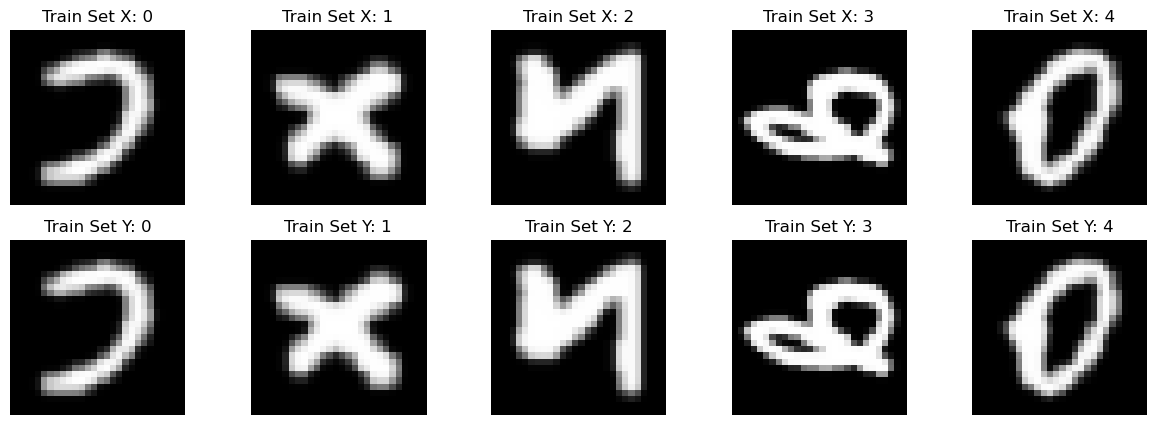

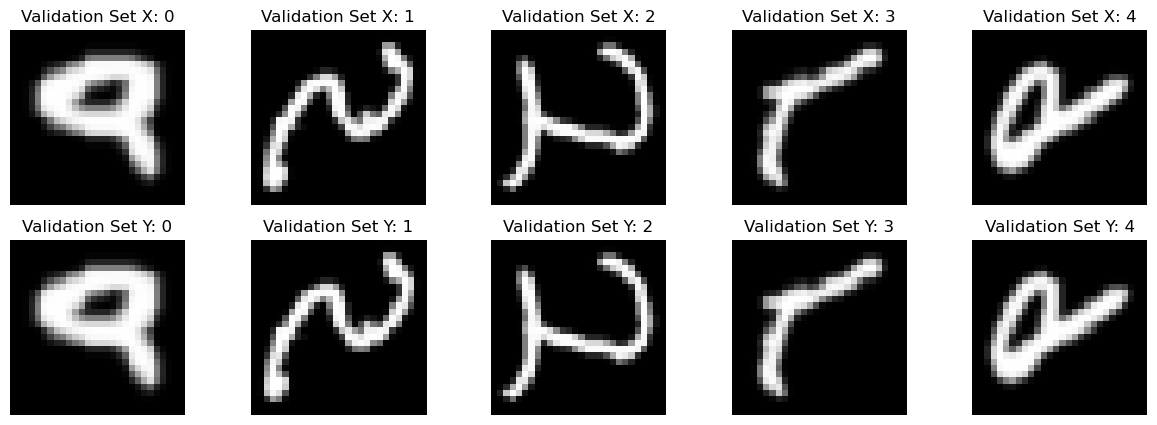

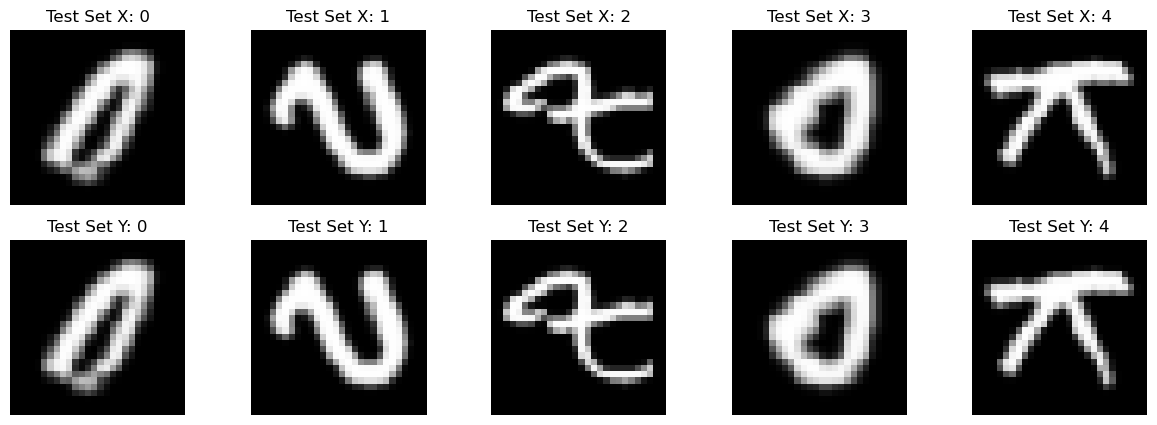

In [8]:
np.random.seed(42)  # for reproducibility

num_samples = 10
train_samples_indices = np.random.choice(len(X_train), num_samples, replace=False)
val_samples_indices   = np.random.choice(len(X_val),   num_samples, replace=False)
test_samples_indices  = np.random.choice(len(X_test),  num_samples, replace=False)

train_samples = X_train[train_samples_indices]
val_samples   = X_val[val_samples_indices]
test_samples  = X_test[test_samples_indices]

# For an autoencoder, input=target, so Y is the same
plot_images(train_samples, train_samples, "Train Set")
plot_images(val_samples,   val_samples,   "Validation Set")
plot_images(test_samples,  test_samples,  "Test Set")

# Model Training and Validation

In [ ]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImageGraphAutoencoder(
    in_channels=1,
    feature_dim=32,
    node_dim=32,
    encoder_hidden=16,
    decoder_hidden=16,
    gcn_encoder_layers=1,
    gcn_decoder_layers=1
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
epochs = 20
best_val_loss = float('inf')


for epoch in range(epochs):
    # -------------------------
    # Training
    # -------------------------
    model.train()
    epoch_train_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for batch in train_pbar:
        batch_inputs = batch[0].to(device)  # (inputs, targets) but here targets == inputs for autoencoder
        
        optimizer.zero_grad()
        reconstructed, _ = model(batch_inputs)
        
        loss = criterion(reconstructed, batch_inputs)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        # Optionally update tqdm bar with current loss
        train_pbar.set_postfix({"train_loss": loss.item()})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    epoch_val_loss = 0.0
    
    # Wrap val_loader with tqdm for a progress bar
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_pbar:
            batch_inputs = batch[0].to(device)
            reconstructed, _ = model(batch_inputs)
            
            loss = criterion(reconstructed, batch_inputs)
            epoch_val_loss += loss.item()
            
            # Optionally update tqdm bar with current val loss
            val_pbar.set_postfix({"val_loss": loss.item()})
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved with validation loss: {avg_val_loss:.4f}")
    
    
    # -------------------------
    # Logging
    # -------------------------
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 [Train]:   0%|          | 2/439 [02:23<9:00:27, 74.20s/it, train_loss=0.132]

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImageGraphAutoencoder(
    in_channels=1,
    feature_dim=64,
    node_dim=64,
    encoder_hidden=32,
    decoder_hidden=32,
    gcn_encoder_layers=2,
    gcn_decoder_layers=2
).to(device)

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model_best = model.to(device)

# Load last epoch model
model.load_state_dict(torch.load('last_epoch_model.pth', map_location=device))
model_last = model.to(device)

/var/folders/s8/dzq7yrf55y1fnp82gpqwj9f40000gn/T/ipykernel_7508/1086846758.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

In [ ]:
num_samples = 10
test_samples_indices = np.random.choice(len(X_test), num_samples, replace=False)
test_samples = X_test[test_samples_indices].to(device)

In [ ]:
# Function to plot images
def plot_images(original, reconstructed, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        # Plot original images
        plt.subplot(2, 5, i + 1)
        plt.imshow(original[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Original {i}", fontsize=12)
        plt.axis('off')
        
        # Plot reconstructed images
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Reconstructed {i}", fontsize=12)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

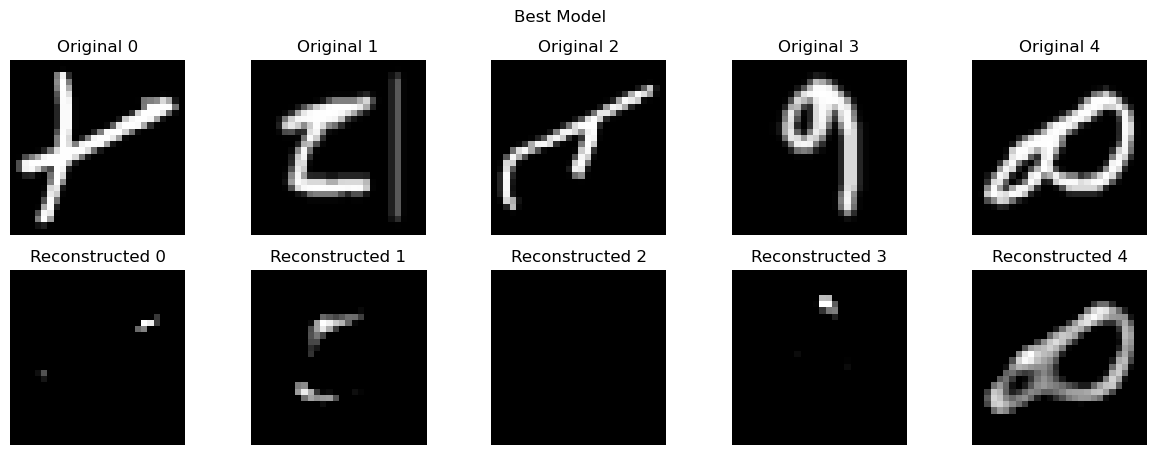

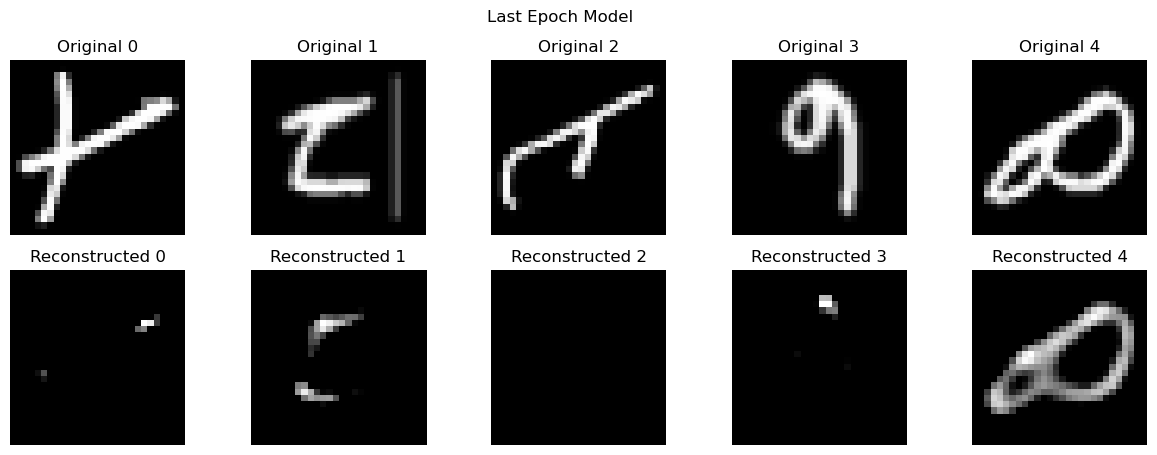

In [48]:
# Reconstruct using best model
model_best.eval()
with torch.no_grad():
    reconstructed_best, graph_representations_best = model_best(test_samples)

# Reconstruct using last epoch model
model_last.eval()
with torch.no_grad():
    reconstructed_last, _ = model_last(test_samples)

# Plot original vs reconstructed images for best model
plot_images(test_samples, reconstructed_best, "Best Model")

# Plot original vs reconstructed images for last epoch model
plot_images(test_samples, reconstructed_last, "Last Epoch Model")

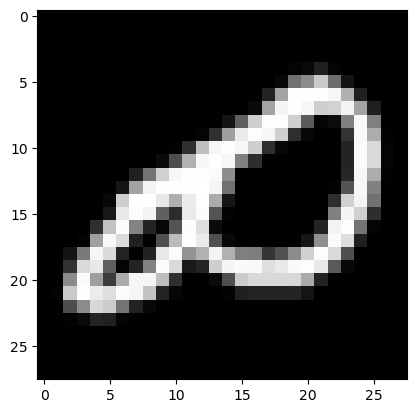

In [46]:
plt.imshow(test_samples[4].cpu().squeeze(),cmap='gray')

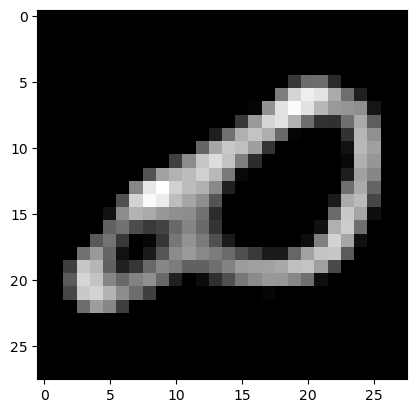

In [47]:
plt.imshow(reconstructed_best[4].cpu().squeeze(),cmap='gray')

In [61]:
def plot_transition_matrix(transition_matrix, threshold=0.1):
    G = nx.DiGraph()
    num_nodes = transition_matrix.shape[0]
    
    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)
    
    # Add edges with probabilities
    for i in range(num_nodes):
        for j in range(num_nodes):
            prob = transition_matrix[i, j]
            if prob >= threshold:
                G.add_edge(i, j, weight=prob)
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(12, 12))  # Bigger plot size
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)  # Smaller node size
    
    # Draw edges
    edges = G.edges(data=True)
    high_prob_edges = [(u, v) for u, v, d in edges if d['weight'] >= threshold]
    low_prob_edges = [(u, v) for u, v, d in edges if d['weight'] < threshold]
    
    nx.draw_networkx_edges(G, pos, edgelist=high_prob_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=low_prob_edges, edge_color='b', arrows=True, style='dashed')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
    
    # Draw edge labels for low probability edges
    edge_labels = {(u, v): d['label'] for u, v, d in edges if 'label' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=6)
    
    plt.title("Transition Matrix Graph")
    plt.show()

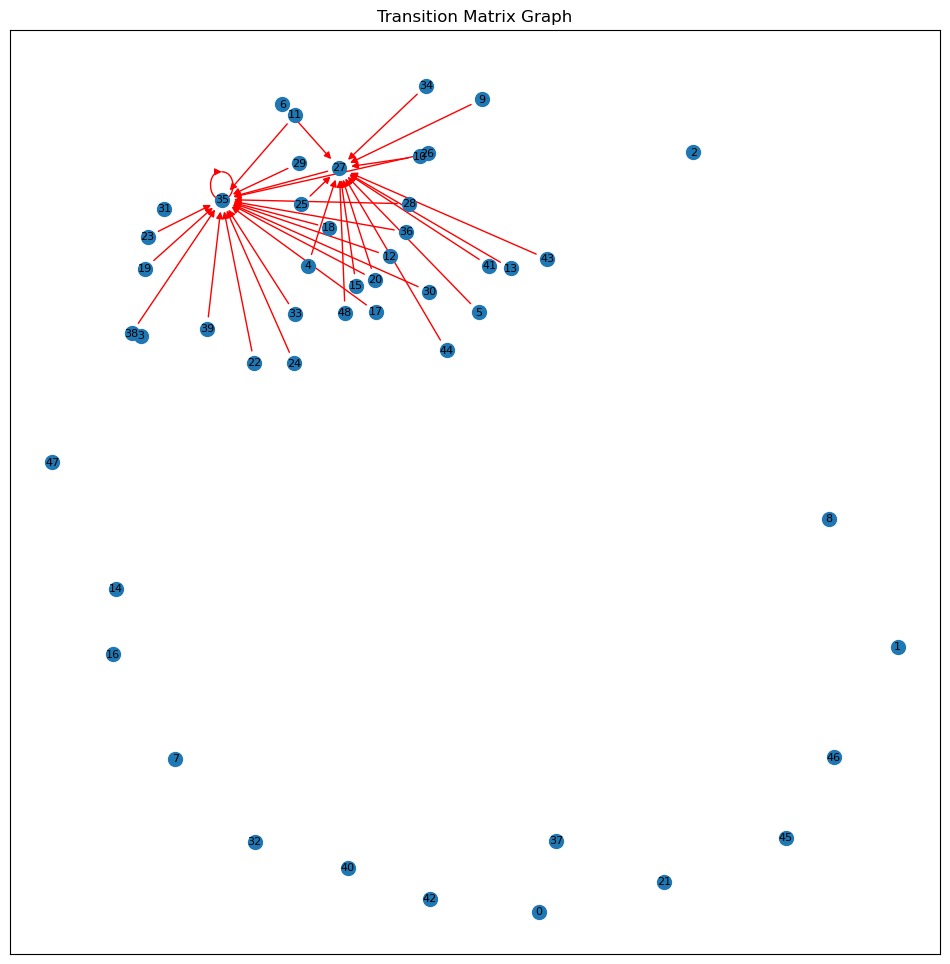

In [64]:
plot_transition_matrix(graph_representations_best[4][1], threshold=0.06)

In [78]:
def plot_nodes_with_edges(node_vectors, transition_matrix, threshold=0.05, color_component=2):
    # Apply PCA to reduce node vectors to 3D
    pca = PCA(n_components=3)
    reduced_vectors = pca.fit_transform(node_vectors)
    
    # Create a graph
    G = nx.DiGraph()
    num_nodes = transition_matrix.shape[0]
    
    # Add nodes with positions
    for i in range(num_nodes):
        G.add_node(i, pos=(reduced_vectors[i, 0], reduced_vectors[i, 1]), color=reduced_vectors[i, color_component])
    
    # Add edges with probabilities
    for i in range(num_nodes):
        for j in range(num_nodes):
            prob = transition_matrix[i, j]
            if prob > threshold:
                G.add_edge(i, j, weight=prob)
    
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[i]['color'] for i in G.nodes]
    
    plt.figure(figsize=(12, 12))  # Bigger plot size
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=colors, cmap=plt.cm.viridis)
    
    # Draw edges
    edges = G.edges(data=True)
    high_prob_edges = [(u, v) for u, v, d in edges if d['weight'] > threshold]
    
    nx.draw_networkx_edges(G, pos, edgelist=high_prob_edges, edge_color='r', arrows=True)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label=f'PCA Component {color_component + 1}')
    
    plt.title("Nodes with Edges (PCA Reduced)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

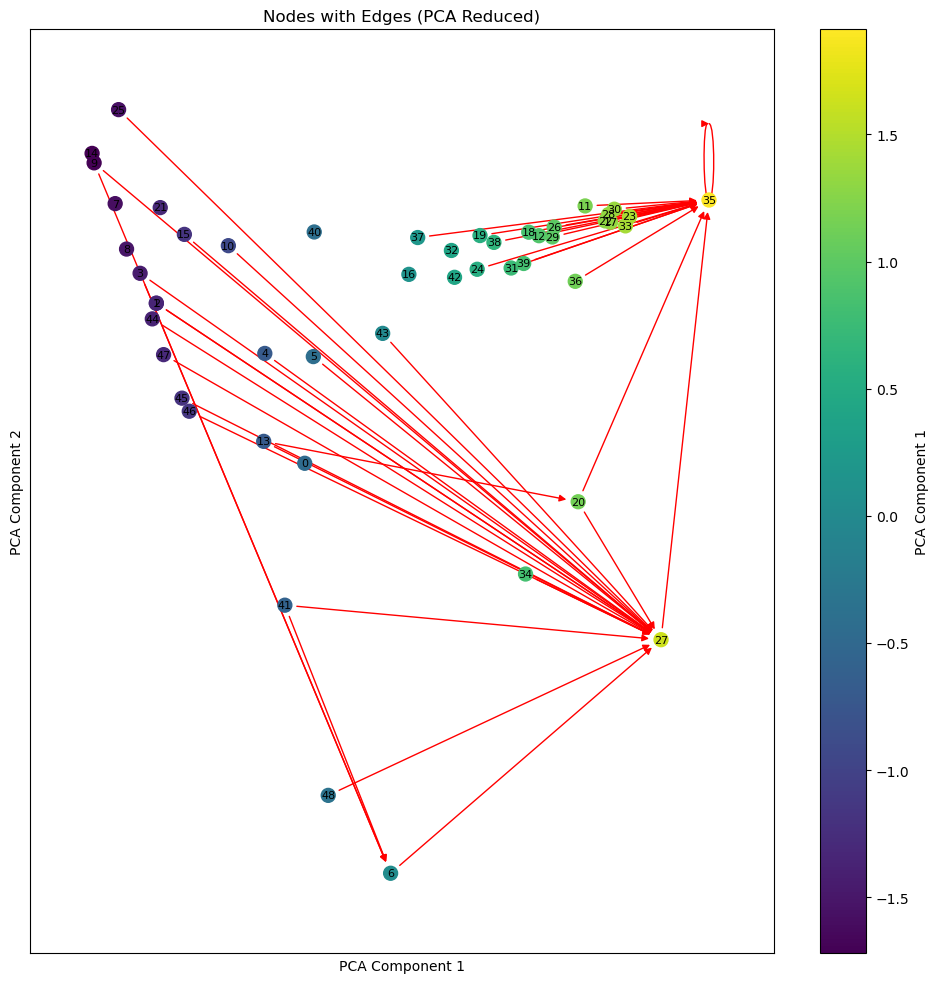

In [97]:
plot_nodes_with_edges(graph_representations_best[4][0], graph_representations_best[4][1], threshold=0.055,color_component=0)

In [91]:
def plot_nodes_with_edges_3d(node_vectors, transition_matrix, threshold=0.05):
    # Apply PCA to reduce node vectors to 3D
    pca = PCA(n_components=3)
    reduced_vectors = pca.fit_transform(node_vectors)
    
    # Create a graph
    G = nx.DiGraph()
    num_nodes = transition_matrix.shape[0]
    
    # Add nodes with positions
    for i in range(num_nodes):
        G.add_node(i, pos=(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2]))
    
    # Add edges with probabilities
    for i in range(num_nodes):
        for j in range(num_nodes):
            prob = transition_matrix[i, j]
            if prob > threshold:
                G.add_edge(i, j, weight=prob)
    
    pos = nx.get_node_attributes(G, 'pos')
    
    fig = plt.figure(figsize=(12, 12))  # Bigger plot size
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw nodes
    xs = [pos[i][0] for i in G.nodes]
    ys = [pos[i][1] for i in G.nodes]
    zs = [pos[i][2] for i in G.nodes]
    ax.scatter(xs, ys, zs, s=100, c='blue', depthshade=True)
    
    # Draw edges
    edges = G.edges(data=True)
    high_prob_edges = [(u, v) for u, v, d in edges if d['weight'] > threshold]
    
    for u, v in high_prob_edges:
        x = [pos[u][0], pos[v][0]]
        y = [pos[u][1], pos[v][1]]
        z = [pos[u][2], pos[v][2]]
        ax.plot(x, y, z, c='r')
    
    ax.set_title("Nodes with Edges (PCA Reduced 3D)")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    
    plt.show()


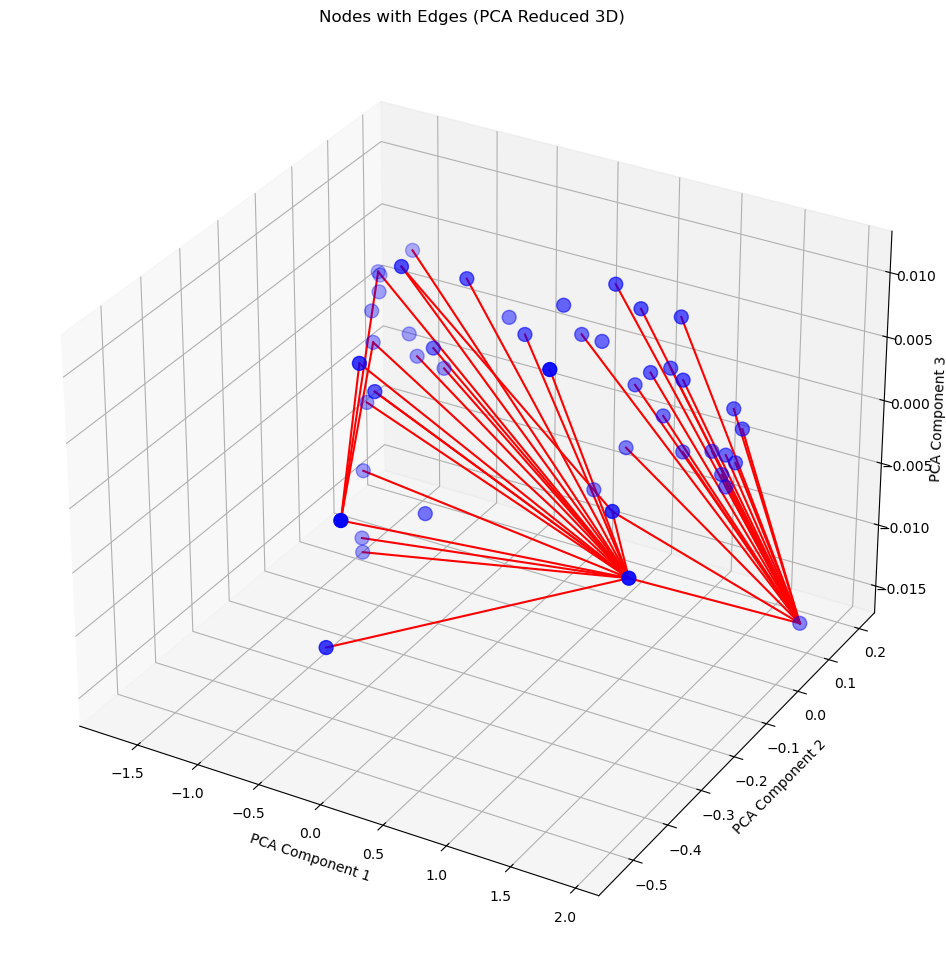

In [98]:
plot_nodes_with_edges_3d(graph_representations_best[4][0], graph_representations_best[4][1], threshold=0.055)